In [1]:
import pandas as pd
import panel as pn
import numpy as np
from sqlalchemy import create_engine
from datetime import date, timedelta
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set

pn.extension('tabulator')

engine = create_engine("mysql+pymysql://root:@localhost:3306/stock")
const = engine.connect()
engine = create_engine("sqlite:///c:\\ruby\\portmy\\db\\development.sqlite3")
conmy = engine.connect()
format_dict = {
               'fm_price':'{:.2f}','to_price':'{:.2f}','price':'{:.2f}',    
               'max_price':'{:.2f}','min_price':'{:.2f}','maxp':'{:.2f}','minp':'{:.2f}',
               'opnp':'{:.2f}','target':'{:.2f}','max':'{:.2f}','max52':'{:.2f}',
               'css_price':'{:.2f}','amount':'{:,.2f}','unit_cost':'{:.2f}',
               'cost_amt':'{:,.2f}','dividend_amount':'{:,.2f}','base':'{:,.2f}',
               'dividend':'{:.2f}','div_amt':'{:,.2f}',
               'cost_pct':'{:.2f}%','mkt_pct':'{:.2f}%','pft_pct':'{:.2f}%','pct':'{:.2f}%', 
               'buy_target':'{:.2f}','sell_target':'{:.2f}',
               'volume':'{:,.2f}','beta':'{:.2f}','cost':'{:,.2f}','profit':'{:,.2f}',
               'qty':'{:,}','available_qty':'{:,}','shares':'{:,}','volbuy':'{:,}','div_rank':'{:,}','amt_rank':'{:,}'}
pd.set_option("display.max_rows", None)

data_path = "../data/"
csv_path = "\\Users\\User\\iCloudDrive\\"
box_path = "\\Users\\User\\Dropbox\\"

today = date.today()
today

datetime.date(2021, 12, 30)

### Set today = last closed work day

In [2]:
#today = today - timedelta(days=1)
today

datetime.date(2021, 12, 30)

### Restart and Run All Cells

In [3]:
sql = '''
UPDATE buy B
SET dividend =
(SELECT DIVIDEND FROM dividend D
WHERE B.name = D.name)'''
rp = const.execute(sql)
rp.rowcount

33

### Process portfolio (table buy in mysql stock)

In [4]:
sql = '''
SELECT name, volbuy AS shares, price AS unit_cost, volbuy * price AS cost, dividend,
volbuy * dividend AS div_amt, FORMAT((volbuy * dividend)/(volbuy * price) * 100,2) AS cost_pct, period
FROM buy
WHERE active = 1'''
df_buy = pd.read_sql(sql, const)
df_buy['shares'] = df_buy.shares.astype(int)
df_buy['cost_pct'] = df_buy.cost_pct.astype(float)
df_buy.sort_values(['period'],ascending=[False]).shape

(33, 8)

In [5]:
file_name = 'hi-dividend.csv'
data_file = data_path + file_name
output_file = csv_path + file_name
box_file = box_path + file_name
data_file, output_file, box_file

('../data/hi-dividend.csv',
 '\\Users\\User\\iCloudDrive\\hi-dividend.csv',
 '\\Users\\User\\Dropbox\\hi-dividend.csv')

In [6]:
df_buy.sort_values(['cost_pct'],ascending=[False]).to_csv(output_file)
df_buy.sort_values(['cost_pct'],ascending=[False]).to_csv(data_file)
df_buy.sort_values(['cost_pct'],ascending=[False]).to_csv(box_file)

In [7]:
target = 650000
dividend = df_buy.div_amt.sum()
remain = target - dividend
dividend, target, remain

(636053.44, 650000, 13946.560000000056)

### Start of Period Calculation

In [8]:
sql = '''
SELECT B.name, volbuy AS shares, B.price AS unit_cost, volbuy * B.price AS cost, 
dividend, volbuy * dividend AS div_amt, 
FORMAT((volbuy * dividend)/(volbuy * B.price) * 100,1) AS cost_pct, 
P.price, volbuy * P.price AS amount, 
FORMAT((volbuy * dividend)/(volbuy * P.price) * 100,1) AS mkt_pct,
(P.price - B.price) * volbuy AS profit, 
FORMAT(((P.price - B.price) * volbuy) / (volbuy * B.price) * 100,1) AS pft_pct, period
FROM buy B JOIN price P
ON B.name = P.name
WHERE P.date = "%s"
AND active = 1'''
sql = sql % today 
print(sql)


SELECT B.name, volbuy AS shares, B.price AS unit_cost, volbuy * B.price AS cost, 
dividend, volbuy * dividend AS div_amt, 
FORMAT((volbuy * dividend)/(volbuy * B.price) * 100,1) AS cost_pct, 
P.price, volbuy * P.price AS amount, 
FORMAT((volbuy * dividend)/(volbuy * P.price) * 100,1) AS mkt_pct,
(P.price - B.price) * volbuy AS profit, 
FORMAT(((P.price - B.price) * volbuy) / (volbuy * B.price) * 100,1) AS pft_pct, period
FROM buy B JOIN price P
ON B.name = P.name
WHERE P.date = "2021-12-30"
AND active = 1


In [9]:
df_buy_price = pd.read_sql(sql, const)
df_buy_price.shape

(33, 13)

In [10]:
df_buy_price['shares'] = df_buy_price.shares.astype(int)
df_buy_price['cost_pct'] = df_buy_price.cost_pct.astype(float)
df_buy_price['mkt_pct'] = df_buy_price.mkt_pct.astype(float)
df_buy_price['pft_pct'] = df_buy_price.pft_pct.astype(float)
#df_buy_price.set_index('name',inplace=True)
df_buy_price.sort_values(['period','pft_pct'],ascending=[True,True]).shape

(33, 13)

In [11]:
df_buy_price.nlargest(5, 'cost')[['name','cost','amount','div_amt','cost_pct','mkt_pct']].style.format(format_dict)

,name,cost,amount,div_amt,cost_pct,mkt_pct
5,MCS,"1,002,000.00","888,000.00","82,200.00",8.20%,9.30%
12,JASIF,"1,000,000.00","1,030,000.00","95,000.00",9.50%,9.20%
6,DIF,"882,000.00","834,000.00","62,640.00",7.10%,7.50%
3,IVL,"756,000.00","778,500.00","15,300.00",2.00%,2.00%
0,STA,"695,000.00","620,000.00","105,000.00",15.10%,16.90%


In [13]:
df_buy_price.nsmallest(5, 'cost')[['name','cost','amount','div_amt','cost_pct','mkt_pct']].style.format(format_dict)

,name,cost,amount,div_amt,cost_pct,mkt_pct
17,SIS,"56,250.00","66,000.00","1,500.00",2.70%,2.30%
26,IMH,"66,000.00","75,600.00",nan,nan%,nan%
23,TSTH,"112,500.00","109,500.00",nan,nan%,nan%
27,DCC,"116,000.00","113,600.00","7,360.00",6.30%,6.50%
31,RJH,"148,500.00","147,375.00","7,650.00",5.20%,5.20%


In [15]:
file_name = 'buy-div-price.csv'
data_file = data_path + file_name
output_file = csv_path + file_name
box_file = box_path + file_name

df_buy_price.sort_values(['period','name'],ascending=[True,True]).to_csv(output_file)
df_buy_price.sort_values(['period','name'],ascending=[True,True]).to_csv(data_file)
df_buy_price.sort_values(['period','name'],ascending=[True,True]).to_csv(box_file)

### Short term stocks

In [16]:
short_term = df_buy_price.period == '4'
df_buy_price.loc[short_term].sort_values(['pft_pct'],ascending=[False]).style.format(format_dict)

,name,shares,unit_cost,cost,dividend,div_amt,cost_pct,price,amount,mkt_pct,profit,pft_pct,period
25,KBANK,"2,400",136.50,"327,600.00",3.00,"7,200.00",2.20%,142.00,"340,800.00",2.10%,"13,200.00",4.00%,4
2,SAT,"7,500",21.10,"158,250.00",0.88,"6,600.00",4.20%,21.80,"163,500.00",4.00%,"5,250.00",3.30%,4
3,IVL,"18,000",42.00,"756,000.00",0.85,"15,300.00",2.00%,43.25,"778,500.00",2.00%,"22,500.00",3.00%,4
28,BGRIM,"9,000",40.00,"360,000.00",0.45,"4,050.00",1.10%,40.50,"364,500.00",1.10%,"4,500.00",1.30%,4
31,RJH,"4,500",33.00,"148,500.00",1.70,"7,650.00",5.20%,32.75,"147,375.00",5.20%,"-1,125.00",-0.80%,4
10,TOP,"3,000",50.00,"150,000.00",1.30,"3,900.00",2.60%,49.50,"148,500.00",2.60%,"-1,500.00",-1.00%,4
27,DCC,"40,000",2.90,"116,000.00",0.18,"7,360.00",6.30%,2.84,"113,600.00",6.50%,"-2,400.00",-2.10%,4
29,SCC,600,405.00,"243,000.00",10.00,"5,999.94",2.50%,386.00,"231,600.00",2.60%,"-11,400.00",-4.70%,4
22,NER,"36,000",7.45,"268,200.00",0.22,"7,920.00",3.00%,7.00,"252,000.00",3.10%,"-16,200.00",-6.00%,4
19,TU,"18,000",20.80,"374,400.00",0.85,"15,300.00",4.10%,19.50,"351,000.00",4.40%,"-23,400.00",-6.30%,4


In [17]:
p4cost = df_buy_price.loc[short_term].cost.sum()
p4profit = df_buy_price.loc[short_term].profit.sum()
p4pct = round(p4profit/p4cost*100, 2)
p4cost, p4profit, p4pct, df_buy_price.loc[short_term].shape[0]

(2901950.0, -10575.0, -0.36, 10)

### Long term stocks

In [18]:
long_term = df_buy_price.period == '3'
df_buy_price[long_term].sort_values(['pft_pct'],ascending=[False]).shape

(13, 13)

In [19]:
df_buy_price[long_term].nlargest(5, 'pft_pct')[['name','cost','amount','profit','pft_pct']].style.format(format_dict)

,name,cost,amount,profit,pft_pct
17,SIS,"56,250.00","66,000.00","9,750.00",17.30%
26,IMH,"66,000.00","75,600.00","9,600.00",14.50%
30,RCL,"193,500.00","221,625.00","28,125.00",14.50%
4,KCE,"348,000.00","352,000.00","4,000.00",1.10%
8,GLOBAL,"150,000.00","150,000.00",0.00,0.00%


In [20]:
p3cost = df_buy_price.loc[long_term].cost.sum()
p3profit = df_buy_price.loc[long_term].profit.sum()
p3pct = round(p3profit/p3cost*100, 2)
p3cost, p3profit, p3pct,df_buy_price.loc[long_term].shape[0]

(2405550.0, -4675.0, -0.19, 13)

### High dividend stocks

In [21]:
hi_dividend = df_buy_price.period == '2'
df_buy_price.loc[hi_dividend].sort_values(['mkt_pct'],ascending=[False])

,name,shares,unit_cost,cost,dividend,div_amt,cost_pct,price,amount,mkt_pct,profit,pft_pct,period
0,STA,20000,34.75,695000.0,5.2500,105000.0,15.1,31.00,620000.0,16.9,-75000.0,-10.8,2
21,NOBLE,63000,7.00,441000.0,0.8500,53550.0,12.1,6.15,387450.0,13.8,-53550.0,-12.1,2
7,TMT,27000,10.50,283500.0,1.1000,29700.0,10.5,10.30,278100.0,10.7,-5400.0,-1.9,2
5,MCS,60000,16.70,1002000.0,1.3700,82200.0,8.2,14.80,888000.0,9.3,-114000.0,-11.4,2
12,JASIF,100000,10.00,1000000.0,0.9500,95000.0,9.5,10.30,1030000.0,9.2,30000.0,3.0,2
16,HREIT,30000,8.95,268500.0,0.6932,20796.0,7.7,9.05,271500.0,7.7,3000.0,1.1,2
6,DIF,60000,14.70,882000.0,1.0440,62640.0,7.1,13.90,834000.0,7.5,-48000.0,-5.4,2
1,RATCH,9000,45.75,411750.0,3.2500,29250.0,7.1,45.00,405000.0,7.2,-6750.0,-1.6,2
14,TISCO,2000,97.50,195000.0,6.3000,12600.0,6.5,96.00,192000.0,6.6,-3000.0,-1.5,2


In [22]:
df_buy_price[hi_dividend].nlargest(5, 'mkt_pct')[['name','cost','amount','div_amt','cost_pct','mkt_pct']]\
.style.format(format_dict)

,name,cost,amount,div_amt,cost_pct,mkt_pct
0,STA,"695,000.00","620,000.00","105,000.00",15.10%,16.90%
21,NOBLE,"441,000.00","387,450.00","53,550.00",12.10%,13.80%
7,TMT,"283,500.00","278,100.00","29,700.00",10.50%,10.70%
5,MCS,"1,002,000.00","888,000.00","82,200.00",8.20%,9.30%
12,JASIF,"1,000,000.00","1,030,000.00","95,000.00",9.50%,9.20%


In [23]:
p2profit = df_buy_price.loc[hi_dividend].profit.sum()
p2cost = df_buy_price.loc[hi_dividend].cost.sum()
p2dividend = df_buy_price.loc[hi_dividend].div_amt.sum()
p2yield = round(p2profit/p2cost*100,2)
p2cost, p2profit, p2yield, p2dividend, df_buy_price.loc[hi_dividend].shape[0]

(5178750.0, -272700.0, -5.27, 490736.0, 9)

### Disposal stocks

In [24]:
disposal = df_buy_price.period == '1'
df_buy_price.loc[disposal].sort_values(['pft_pct'],ascending=[True]).style.format(format_dict)

,name,shares,unit_cost,cost,dividend,div_amt,cost_pct,price,amount,mkt_pct,profit,pft_pct,period
15,PTTGC,"4,400",66.75,"293,700.00",3.00,"13,200.00",4.50%,58.75,"258,500.00",5.10%,"-35,200.00",-12.00%,1


In [25]:
p1cost = df_buy_price.loc[disposal].cost.sum()
p1profit = df_buy_price.loc[disposal].profit.sum()
p1pct = round(p1profit/p1cost*100,2)
p1cost, p1profit, p1pct,df_buy_price.loc[disposal].shape[0]

(293700.0, -35200.0, -11.99, 1)

### Discrepancies calculation

In [24]:
sql = '''
SELECT *
FROM buy
WHERE active = 1'''
df = pd.read_sql(sql, const)
df['cost_amt'] = df.volbuy * df.price
df.shape

(34, 11)

In [25]:
sql = '''
SELECT name, market
FROM stocks
ORDER BY name'''
my_stocks = pd.read_sql(sql, conmy)
my_stocks.shape

(376, 2)

In [26]:
filters = [
   (my_stocks.market.str.contains('SET50')),
   (my_stocks.market.str.contains('SET100')),
   (my_stocks.market.str.contains('mai'))    
]
values = [450000.0,300000.0,150000.0]

In [27]:
my_stocks["base"] = np.select(filters, values, default=150000)
my_stocks.head()

,name,market,base
0,2S,SET,150000.0
1,AAV,SET100 / SETTHSI,300000.0
2,ACE,SET100,300000.0
3,ADVANC,SET50 / SETHD / SETTHSI,450000.0
4,AEONTS,SET100,300000.0


In [28]:
df_merge = pd.merge(df,my_stocks,on='name',how='inner')
df_merge.shape

(34, 13)

In [29]:
cols = 'name period volbuy price cost_amt base pct'.split()
df_merge['pct'] = round(df_merge.cost_amt/df_merge.base*100,2)
df_merge['volbuy'] = df_merge['volbuy'].astype(int)
mask = df.period != '2'
df_merge[mask][cols].shape

(25, 7)

In [30]:
df_merge[mask].nsmallest(3, 'pct')[cols].style.format(format_dict)

,name,period,volbuy,price,cost_amt,base,pct
8,GLOBAL,3,"7,500",20.00,"150,000.00","450,000.00",33.33%
11,TOP,4,"3,000",50.00,"150,000.00","450,000.00",33.33%
18,SIS,3,"1,500",37.50,"56,250.00","150,000.00",37.50%


In [31]:
df_merge[mask].nlargest(3, 'pct')[cols].style.format(format_dict)

,name,period,volbuy,price,cost_amt,base,pct
23,NER,4,"36,000",7.45,"268,200.00","150,000.00",178.80%
3,IVL,4,"18,000",42.00,"756,000.00","450,000.00",168.00%
31,RCL,3,"4,500",43.00,"193,500.00","150,000.00",129.00%


### Rank

In [32]:
colt = 'name shares unit_cost cost price amount mkt_pct div_rnk amt_rnk div_amt'.split()

In [33]:
df2 = df_buy_price[df_buy_price['period'] == '2'].copy()
df2['div_rnk'] = df2.mkt_pct.rank(ascending=False)
df2['amt_rnk'] = df2.amount.rank(ascending=False)
df2_out = df2[colt].sort_values('div_rnk')
df2_tab = pn.widgets.Tabulator(df2_out, layout='fit_data', width=900)
df2_tab

Tabulator(layout='fit_data', value=     name  shares  ..., width=900)

In [34]:
df2_out.div_amt.sum()

490736.0

In [35]:
df_buy_price.period.value_counts()

3    13
4    11
2     9
1     1
Name: period, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


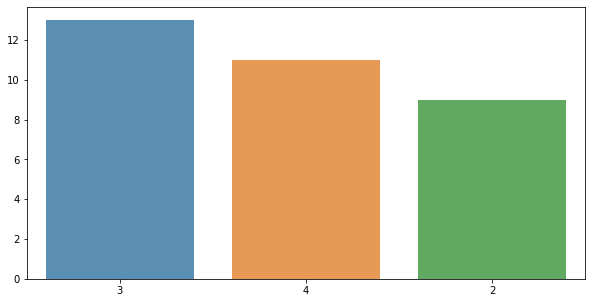

In [36]:
Period_Count =\
df_buy_price.period.value_counts(sort=True).nlargest(3)
plt.figure(figsize=(10,5))
sns.barplot(Period_Count.index,
Period_Count.values, alpha=0.8)
plt.show()

In [37]:
df9 = df_buy_price[df_buy_price['period'] != '2'].copy()
df9['div_rnk'] = df9.mkt_pct.rank(ascending=False)
df9['amt_rnk'] = df9.amount.rank(ascending=False)
df9_out = df9[colt].sort_values('div_rnk')
df9_tab = pn.widgets.Tabulator(df9_out, layout='fit_data', width=900)
df9_tab

Tabulator(layout='fit_data', value=      name  shares  ..., width=900)

In [38]:
df9_out.div_amt.sum()

152367.44

In [39]:
df_buy_price.loc[short_term]

,name,shares,unit_cost,cost,dividend,div_amt,cost_pct,price,amount,mkt_pct,profit,pft_pct,period
2,SAT,7500,21.10,158250.0,0.8800,6600.00,4.2,21.40,160500.0,4.1,2250.0,1.4,4
3,IVL,18000,42.00,756000.0,0.8500,15300.00,2.0,42.75,769500.0,2.0,13500.0,1.8,4
9,VNT,4500,37.50,168750.0,0.9000,4050.00,2.4,38.50,173250.0,2.3,4500.0,2.7,4
11,TOP,3000,50.00,150000.0,1.3000,3900.00,2.6,49.25,147750.0,2.6,-2250.0,-1.5,4
20,TU,18000,20.80,374400.0,0.8500,15300.00,4.1,19.30,347400.0,4.4,-27000.0,-7.2,4
23,NER,36000,7.45,268200.0,0.2200,7920.00,3.0,7.05,253800.0,3.1,-14400.0,-5.4,4
26,KBANK,2400,136.50,327600.0,3.0000,7200.00,2.2,141.00,338400.0,2.1,10800.0,3.3,4
28,DCC,40000,2.90,116000.0,0.1840,7360.00,6.3,2.82,112800.0,6.5,-3200.0,-2.8,4
29,BGRIM,9000,40.00,360000.0,0.4500,4050.00,1.1,40.00,360000.0,1.1,0.0,0.0,4
30,SCC,600,405.00,243000.0,9.9999,5999.94,2.5,382.00,229200.0,2.6,-13800.0,-5.7,4


In [40]:
data = df_buy_price.loc[short_term]
names = data['name']
in_p = ", ".join(map(lambda name: "'%s'" % name, names))
in_p

"'SAT', 'IVL', 'VNT', 'TOP', 'TU', 'NER', 'KBANK', 'DCC', 'BGRIM', 'SCC', 'RJH'"

In [41]:
sql = '''
SELECT name, min_price AS min, price, max_price AS max 
FROM stocks
WHERE name IN (%s)'''
sql = sql % in_p
stocks = pd.read_sql(sql, conmy)
stocks.set_index('name',inplace=True)
stocks

,min,price,max
name,,,
BGRIM,38.25,40.00,56.00
DCC,2.22,2.82,3.40
IVL,33.75,43.00,50.00
KBANK,101.00,138.00,153.00
NER,4.10,7.05,8.65
RJH,23.10,32.50,39.00
SAT,15.70,21.20,23.50
SCC,364.00,379.00,474.00
TOP,42.50,48.25,66.00


In [42]:
stocks.drop('SCC',inplace=True)
stocks

,min,price,max
name,,,
BGRIM,38.25,40.00,56.00
DCC,2.22,2.82,3.40
IVL,33.75,43.00,50.00
KBANK,101.00,138.00,153.00
NER,4.10,7.05,8.65
RJH,23.10,32.50,39.00
SAT,15.70,21.20,23.50
TOP,42.50,48.25,66.00
TU,13.40,19.30,23.00


<AxesSubplot:xlabel='name'>

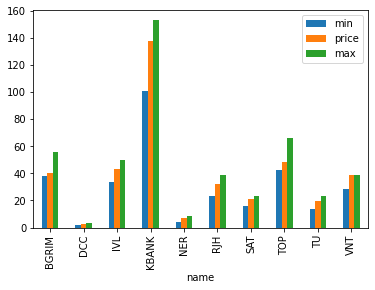

In [43]:
stocks.plot.bar()

<AxesSubplot:xlabel='name', ylabel='price'>

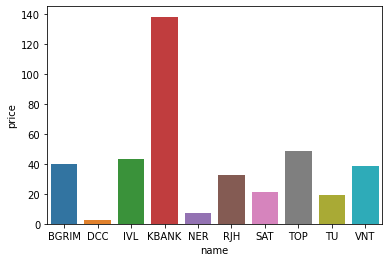

In [44]:
stocks.reset_index('name',inplace=True)
sns.barplot(x='name', y='price', data=stocks)